<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/MELI/Hito_3_de_Mentoria_MELI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [ ]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.sparse as sps

### Data Sets

In [ ]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"

In [ ]:
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))

In [ ]:
train_df = pd.DataFrame(train_data)
train_df.head()

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207


In [ ]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

In [ ]:
item_df = pd.DataFrame(item_data)
del train_data
del item_data
del gz

In [ ]:
item_df.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new


In [ ]:
item_list = item_df['item_id'].tolist()
domain_list = item_df['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

### Armado X esparsa
Se probó el armado de 65000 features (uno por producto posible) en una matriz esparsa. Sin embargo, el problema de clasificación con 65000 features y 65000 clases diferentes resultó demasiado para nuestro poder computacional. 
Se avanza entonces con varios modelos de predicción no optimizados, pero se deja aquí el código del armado de la matriz esparsa, para futura referencia.

In [ ]:
features = train_df.sort_values('item_bought').item_bought.unique().tolist()
features_dict = {feature:features.index(feature) for feature in features}
len(features), len(train_df)

(64928, 413163)

In [ ]:
import scipy.sparse as sps
shape = (413163, 64928)
sampledf = train_df.sample(n=50000, random_state=0)
sampledf.head(1)


,user_history,item_bought
214637,"[{'event_info': 'CADEIRA GAMER', 'event_timest...",12138


In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas
def time_weighing(hours):
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja el mismo resultado
  bitem_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = bitem_prob / 0.199021213390714  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
#Armar la matriz esparsa de X
#Esta matriz toma las consideraciones del Modelo 1 respecto a la ponderación por tiempo
#No es utilizada en el resto del Notebook, pero se deja aquí para mostrar el intento
#de mejorar el modelo con Scikit_Learn
rows = []
cols = []
data = []
current_row = 0
for row in sampledf.itertuples():
  if len(row.user_history) == 1:
    if row.user_history[0]['event_type'] == 'view':
      col = features_dict.get(row.user_history[0]['event_info'])
      if col:
        rows.append(current_row)  #Estructura para matriz esparsa
        cols.append(col)
        data.append(1)
  else:
    most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    for event in row.user_history:
      if event['event_type'] == 'view':
        col = features_dict.get(event['event_info'])
        if col:    
          delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
          rows.append(current_row)
          cols.append(col)
          data.append(time_weighing(delta.total_seconds()/3600)) #se convierte el delta en horas como float
  current_row += 1


In [ ]:
len(features), len(sampledf)

(64928, 50000)

In [ ]:
# Import required package
import numpy as np
from scipy.sparse import csc_matrix
  
# creating sparse matrix
X = csc_matrix((data, (rows, cols)),
                          shape = (len(sampledf), len(features)))
  
X

<50000x64928 sparse matrix of type '<class 'numpy.float64'>'
	with 117747 stored elements in Compressed Sparse Column format>

In [ ]:
#Armar la matriz esparsa de y
rows = []
cols = []
data = []
current_row = 0
for row in train_df.itertuples():
  col = features_dict.get(row.item_bought)
  rows.append(current_row)  #Estructura para matriz esparsa
  cols.append(col)
  data.append(1)
  current_row += 1
# creating sparse matrix


In [ ]:
y = csc_matrix((data, (rows, cols)), shape = (len(train_df), len(features)))
y

<413163x64928 sparse matrix of type '<class 'numpy.longlong'>'
	with 413163 stored elements in Compressed Sparse Column format>

In [ ]:
y = train_df.item_bought.to_numpy()

In [ ]:
y

array([1748830,  228737, 1909110, ..., 2022477, 1111021, 1212472])

In [ ]:
ylist = sampledf['item_bought'].astype(str).tolist()

In [ ]:
with open('y_list_sample.txt', 'w') as f:
    for item in ylist:
        f.write("%s\n" % item)

In [ ]:
import scipy.sparse
scipy.sparse.save_npz('X_sparse_sample.npz', X)
#scipy.sparse.save_npz('y_sparse.npz', y)


###Modelos

#### Baseline
Se predice el último item visto. En caso de no ver ningun item, se predice el item más comprado

In [ ]:
most_common = train_df.groupby('item_bought').count().sort_values('user_history', ascending=False).index.tolist()[0]

In [ ]:
pred_y_baseline = []
def last_viewed_item(events_list):
  for ind in range(len(events_list)):
    if events_list[-ind]['event_type'] == 'view':
      return row.user_history[-ind]['event_info']
  return most_common


for row in train_df.itertuples():
 pred_y_baseline.append(last_viewed_item(row.user_history))

In [ ]:
#Se hace la métrica también para el domain predicho
true_domain = [item_domain_dict[item] for item in train_df.item_bought]
pred_domain_baseline = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_baseline]

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_baseline))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_baseline))

accuracy producto predicho 0.12247466496273868
accuracy domain predicho 0.30380987648942426


#### Modelo 1
Se considera la cantidad de veces que fue visto el item, y se pondera por la antiguedad de la vista

In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas
def time_weighing(hours):
  if hours < 0.001:
    return 1
  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  #Esta curva se calculó con una mezcla de python + otro soft online. Al final de esta notebook, en el
  #modelo 4, se muestra el método de cálculo 100% dentro de python, que arroja un resultado similar
  bitem_prob = -2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)  
  weight = bitem_prob / 0.199021213390714  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
import operator
pred_y_model1 = []
def weighed_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model1.append(weighed_viewed_item(row.user_history))

In [ ]:
pred_domain_model1 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model1]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model1))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model1))

accuracy producto predicho 0.17516573362087118
accuracy domain predicho 0.3717249608508022


#### Modelo 2
Se considera la cantidad de veces que fue visto el item. NO se pondera por la antiguedad de la vista

In [ ]:
pred_y_model2 = []
def most_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + 1
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model2.append(most_viewed_item(row.user_history))

In [ ]:
pred_domain_model2 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model2]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model2))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model2))

accuracy producto predicho 0.1568993351292347
accuracy domain predicho 0.3508663650907753


####Modelo 3
Se considera la cantidad de veces que fue visto el item, se pondera por la antiguedad de la vista, y por la cantidad de veces que fueron vistos otros items del mismo domain

In [ ]:
pred_y_model3 = []
def weighed_time_domain_viewed_item(events_list, strength=0.5):
  items = {}
  domains = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
      domain = item_domain_dict[event['event_info']] if item_domain_dict[event['event_info']] else 'None' #la condition tiene que ver con unos poquísimos items sin dominio
      domains[domain] = domains.get(domain,0) + strength*time_weighing(delta.total_seconds()/3600) #se multiplica por la strength
  if items:  
    for item in items:
      domain = item_domain_dict[item] if item_domain_dict[item] else 'None' #la condition tiene que ver con unos poquísimos items sin dominio
      items[item] += domains[domain]
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model3.append(weighed_time_domain_viewed_item(row.user_history))

In [ ]:
pred_domain_model3 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model3]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model3))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model3))

accuracy producto predicho 0.1727187574879648
accuracy domain predicho 0.37519090528435506


Prueba de diferentes strengths para la ponderación por vistas del mismo domain:

In [ ]:
strengths = [0.1,0.2,0.3,0.7,0.8]
for strength in strengths:
  pred_y_model3_strengths = []
  for row in train_df.itertuples():
    pred_y_model3_strengths.append(weighed_time_domain_viewed_item(row.user_history,strength=strength))
  pred_domain_model3_strengths = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model3_strengths]
  print('strength:',strength)
  print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model3_strengths))
  print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model3_strengths))

strength: 0.1
accuracy producto predicho 0.17469860563506412
accuracy domain predicho 0.37418403874499895
strength: 0.2
accuracy producto predicho 0.17407899545699881
accuracy domain predicho 0.37499727710370967
strength: 0.3
accuracy producto predicho 0.17352715514215938
accuracy domain predicho 0.37516428140951635
strength: 0.7
accuracy producto predicho 0.1720604216737704
accuracy domain predicho 0.37509893189854854
strength: 0.8
accuracy producto predicho 0.1717990236298991
accuracy domain predicho 0.37500695851274196


De acuerdo aumenta la fuerza de la ponderación por haber visto otros items del mismo domain, disminuye el accuracy de predicción de producto comprado, pero aumenta el del domain comprado.

####Modelo 4
Igual al modelo 1, pero con una curva de ponderación por tiempo, calculada dentro de este mismo Notebook para completitud. La accuracy es idéntica a la del modelo 1.

#####Entrenamiento de curvas de ponderación por tiempo

In [ ]:
deltas_list = []
bought_item_list = []
for row in train_df.itertuples():
  bitem = row.item_bought
  if len(row.user_history) == 1:
      deltas_list.append(timedelta(0))
      bought_item_list.append(int(row.user_history[0]['event_info'] == bitem))
  else:
    most_recent_time = datetime.strptime(row.user_history[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
    for event in row.user_history:
      if event['event_type'] == 'view':
          deltas_list.append(most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z'))
          bought_item_list.append(int(event['event_info'] == bitem))
delta_hours_list = [delta.total_seconds()/60/60 for delta in deltas_list]

In [ ]:
delta_bitem_df = pd.DataFrame({'deltas':delta_hours_list, 'bitem':bought_item_list})

In [ ]:
delta_zero_prob = delta_bitem_df[delta_bitem_df.deltas == 0].bitem.mean()
delta_zero_prob

0.19902121339071485

In [ ]:
salto = np.linspace(0,150,15001)[1] - np.linspace(0,150,15001)[0]
bitem_means = [delta_zero_prob]
for hs in np.linspace(0,150,15001):
  bitem_means.append(delta_bitem_df[(delta_bitem_df.deltas>hs)&(delta_bitem_df.deltas<=(hs+salto))].bitem.mean())

In [ ]:
from scipy.optimize import curve_fit
# define the true objective function
#-2.231726 + (0.1984595 - -2.231726)/(1 + (hours/12332420000.000002)**0.1389521)
def objective(x, a, b, c, d):
	return -a  + (delta_zero_prob - -b)/(1+(x/c)**d)
#Se agrega peso al primer punto, para asegurar que la curva pase por el mismo
y_weight = np.empty(len(bitem_means))
y_weight.fill(10)
y_weight[0] = 0.001
# curve fit
popt, _ = curve_fit(objective, np.linspace(0,150.01,15002), bitem_means, sigma=y_weight, absolute_sigma=True)
# summarize the parameter values
a, b, c, d = popt
a, b, c, d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


(0.6371088880359856, 0.637108883872154, 43019.29022548248, 0.22818900272633771)

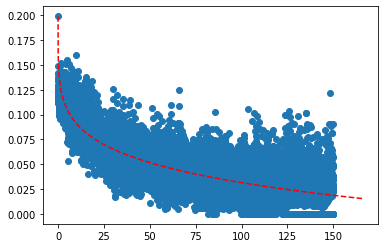

In [ ]:
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(0, max(delta_hours_list), 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
plt.scatter(np.linspace(0,150.01,15002), bitem_means)
plt.plot(x_line, y_line, '--', color='red')
plt.show()

#####Modelo

In [ ]:
#Formula para ponderar la importancia de una vista segun pasan las horas

def time_weighing2(hours):
  if hours < 0.001:
    return 1
  bitem_prob = -a  + (delta_zero_prob - -b)/(1+(hours/c)**d)  #fitted curve de la probabilidad de que la vista sea del bitem, dependiendo de la antiguedad en horas de la vista
  weight = bitem_prob / delta_zero_prob  #bitem_prob para un delta de 0 hours clavado (ultimo item)
  return weight

In [ ]:
pred_y_model4 = []
def weighed_viewed_item(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing2(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:  
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model4.append(weighed_viewed_item(row.user_history))

In [ ]:
pred_domain_model4 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model4]

In [ ]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model4))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model4))

accuracy producto predicho 0.1749115966337741
accuracy domain predicho 0.372361513494674


#### Modelo5: 
Modelo 1, Multiplicando por la P(bitem)

In [101]:
#Calculando P(item sea comprado) y creando un dict para lookup rápido
bitem_count = train_df.groupby('item_bought').count()
bitem_list = bitem_count.index.tolist()
total = len(train_df)
bitem_prob = bitem_count.user_history / total
bitem_prob = bitem_prob.tolist()
bitem_prob_dict = dict(zip(bitem_list, bitem_prob))

In [107]:
pred_y_model6 = []
def weighed_viewed_item_prob(events_list):
  items = {}
  most_recent_time = datetime.strptime(events_list[-1]['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
  for event in events_list:
    if event['event_type'] == 'view':
      delta = most_recent_time - datetime.strptime(event['event_timestamp'], '%Y-%m-%dT%H:%M:%S.%f%z')
      items[event['event_info']] = items.get(event['event_info'],0) + time_weighing(delta.total_seconds()/3600) #se convierte el delta en horas como float
  if items:
    for item in items:
      items[item] *= bitem_prob_dict.get(item,0)
    return max(items.items(), key=operator.itemgetter(1))[0]
  else:
    return most_common

for row in train_df.itertuples():
 pred_y_model6.append(weighed_viewed_item_prob(row.user_history))

In [108]:
pred_domain_model6 = [item_domain_dict[item] if item_domain_dict[item] else 'None' for item in pred_y_model6]

In [109]:
print('accuracy producto predicho', accuracy_score(train_df.item_bought.tolist(), pred_y_model6))
print('accuracy domain predicho', accuracy_score(true_domain, pred_domain_model6))

accuracy producto predicho 0.21340245859382376
accuracy domain predicho 0.4059729453024593
